In [1]:
# for data manipulation
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import gensim.downloader as api
from transformers import BertTokenizer, BertModel
import torch
import warnings
import scipy.sparse

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D , MaxPooling2D ,Dropout , Flatten , Dense ,BatchNormalization ,Concatenate ,Input 
from keras.models import Sequential ,Model
import json

# other libraries
import cv2
import os
import glob
from PIL import Image
import string
import re
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, TruncatedSVD  
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.ensemble import RandomForestClassifier # Added RandomForestClassifier
from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score # Changed metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import classification metrics

# Model
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.svm import SVC
from scipy.stats import iqr # For Silverman's rule
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

# RLAC MODEL
from sklearn.random_projection import GaussianRandomProjection
from scipy.stats import gaussian_kde
import diptest
from scipy.signal import find_peaks  
from sklearn.neighbors import KernelDensity  
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from scipy import stats
from scipy.special import eval_hermitenorm  # For normalized Hermite polynomials H_n(x)
from scipy.stats import skew
from scipy.stats import norm
from sklearn.metrics import (adjusted_mutual_info_score, adjusted_rand_score, 
                             homogeneity_score, completeness_score, v_measure_score,
                             fowlkes_mallows_score, silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score)

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Albiona Shehu\.cache\kagglehub\datasets\uciml\breast-cancer-wisconsin-data\versions\2


In [3]:
data = pd.read_csv(r"\.cache\kagglehub\datasets\uciml\breast-cancer-wisconsin-data\versions\2\data.csv")
data.shape

(569, 33)

In [4]:
# Check for missing values explicitly (though info() already does this)
print("\nMissing values per column:")
print(data.isnull().sum().any()) # Should be False as per dataset description

print("\nDiagnosis value counts:")
print(data['diagnosis'].value_counts())

# Basic statistics for numerical features (excluding ID for now)
print("\nDescriptive statistics (sample):")
print(data.iloc[:, 2:].describe()) # Show stats for actual features


Missing values per column:
True

Diagnosis value counts:
diagnosis
B    357
M    212
Name: count, dtype: int64

Descriptive statistics (sample):
       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064   

In [5]:
# Check for and remove duplicates based on features (X)
print("\nChecking for and removing duplicate rows based on features (X)...")
# Check how many duplicate rows exist in X
num_duplicates_X = data.duplicated().sum()
print(f"Number of duplicate rows found in features (X): {num_duplicates_X}")

if num_duplicates_X > 0:
    # Store original number of rows before removing duplicates
    original_count = X.shape[0]

    # Get the indices of rows to keep (non-duplicates - keep='first' is default)
    # This directly modifies X and keeps the first occurrence
    X = X.drop_duplicates(keep='first')

    # Crucially, filter y_labels using the index of the de-duplicated X
    # .loc is preferred for label-based indexing
    y_labels = y_labels.loc[X.index]

    removed_count = original_count - X.shape[0]
    print(f"Removed {removed_count} duplicate rows based on feature values.")
    print(f"New shape of X: {X.shape}")
    print(f"New shape of y_labels: {y_labels.shape}")

    # Sanity check: Ensure shapes and indices still align
    assert X.shape[0] == y_labels.shape[0], "Row counts of X and y_labels do not match after duplicate removal!"
    assert all(X.index == y_labels.index), "Indices of X and y_labels do not match after duplicate removal!"
    print("X and y_labels successfully aligned after duplicate removal.")
else:
    print("No duplicate rows found in features (X).")


Checking for and removing duplicate rows based on features (X)...
Number of duplicate rows found in features (X): 0
No duplicate rows found in features (X).


In [6]:
labels = data['diagnosis']
data = data.drop(columns=['Unnamed: 32', 'id', 'diagnosis'])

In [7]:
# --- Step 4: Encode Target Variable (for evaluation) ---
print("\n--- Step 4: Encode Target Variable ---")
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(labels)
# M (malignant) will likely be 1, B (benign) will be 0. Let's check:
print(f"Original labels: {labels.unique()}, Encoded labels: {np.unique(y_true_encoded)}")
print(f"Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


--- Step 4: Encode Target Variable ---
Original labels: ['M' 'B'], Encoded labels: [0 1]
Mapping: {'B': np.int64(0), 'M': np.int64(1)}


In [8]:
Q1 = data.quantile(0.20) # Or X_scaled_df.quantile(0.25)
Q3 = data.quantile(0.80) # Or X_scaled_df.quantile(0.75)
IQR = Q3 - Q1
outlier_indices_iqr = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)

data = data[~outlier_indices_iqr]
labels = labels[~outlier_indices_iqr]
print(f"Shape after removing outlier rows: {data.shape}")

Shape after removing outlier rows: (468, 30)


In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(data)
y_train = labels


--- Step 6: Dimensionality Reduction (PCA) ---


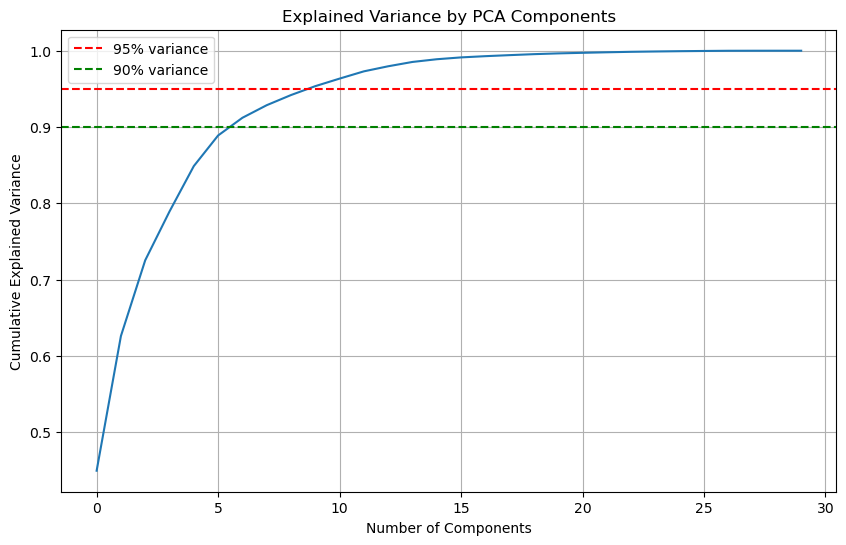

In [10]:
# Let's first see how many components capture significant variance
print("\n--- Step 6: Dimensionality Reduction (PCA) ---")

pca_expl = PCA()
pca_expl.fit(X_train)
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_expl.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% variance')
plt.legend()
plt.show()

In [11]:
results = []

In [1]:
# 4. Apply clustering algorithms
kmeans = KMeans(n_clusters=2, n_init=10, init='random', algorithm='lloyd', max_iter=10, random_state=42)  # Specify the number of clusters
kmeans_labels = kmeans.fit_predict(X_train)

ami_km = adjusted_mutual_info_score(y_train, kmeans_labels)
ari_km = adjusted_rand_score(y_train, kmeans_labels)

results.append(["KMeans", ami_km, ari_km])

NameError: name 'KMeans' is not defined

In [3]:
ncut = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans', n_jobs=-1)  
ncut_labels = ncut.fit_predict(X_train)

ami_nc = adjusted_mutual_info_score(y_train, ncut_labels)
ari_nc = adjusted_rand_score(y_train, ncut_labels)

results.append(["NClust", ami_nc, ari_nc])

NameError: name 'SpectralClustering' is not defined

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

hclust = AgglomerativeClustering(n_clusters=2, linkage='single', metric='euclidean') 
hclust_labels = hclust.fit_predict(X_train)

ami_hc = adjusted_mutual_info_score(y_train, hclust_labels)
ari_hc = adjusted_rand_score(y_train, hclust_labels)

results.append(["HClust", ami_hc, ari_hc])

In [17]:
# Create Pandas DataFrame
results_df = pd.DataFrame(results, columns=["Model", "AMI", "ARI"])

print(results_df)

    Model       AMI       ARI
0  KMeans  0.613722  0.745473
1  NClust  0.639457  0.743058
2  HClust  0.003818  0.005334


In [4]:
import sys
import os

# 1. Get the path of the parent directory (Project_Root)
# '..' means "go up one level"
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# 2. Add it to Python's search path if not already there
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# 3. Now you can import normally
from rlac import RLAC
from mdh import MDH

#print("Successfully imported models from:", parent_dir)

In [19]:
import warnings
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

# Import your custom models
from rlac import RLAC
from mdh import MDH

# --- CONFIGURATION ---
# Target clusters for Aggregation dataset (should be 7)
n_clusters = len(set(y_train))

# RLAC Parameters
rlac_methods = [
    'depth_ratio', 'dip', 'holes', 'min_kurt', 'max_kurt', 
    'negentropy', 'skewness', 'fisher', 'hermite', 'friedman_tukey'
]
rlac_params = {
    'random_state': [43],
    'bw_adjust': [0.05],
    'r': [None]
}
# MDH Parameters (Same as Anuran configuration)
mdh_config = {
    "h_multiplier": 1.0,
    "alphamax_val": 0.9,
    "alpha_steps": 5,
    "random_state": 42
}

results = []

print(f"\nStarting Benchmark on Aggregation Dataset (n={len(X_train)}, k={n_clusters})...")
print("-" * 80)

# ==========================================
# 1. RLAC LOOP
# ==========================================
for method in rlac_methods:
    for r_val in rlac_params['r']:
        for bw in rlac_params['bw_adjust']:
            for seed in rlac_params['random_state']:
                
                # 1. Print parameters BEFORE running
                param_str = f"r={r_val}, bw={bw}, s={seed}"
                print(f"\nRunning RLAC {method:<15} | {param_str} ... ", end="")
                
                try:
                    # 2. Instantiate & Fit
                    model = RLAC(
                        n_clusters=n_clusters,
                        method=method,
                        r=r_val,
                        bw_adjust=bw,
                        random_state=seed,
                        plot=False
                    )
                    
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore", category=UserWarning)
                        model.fit(X_train)
                    
                    # 3. Evaluate
                    ami = adjusted_mutual_info_score(y_train, model.labels_)
                    ari = adjusted_rand_score(y_train, model.labels_)
                    
                    # 4. Log Success
                    print(f"Done (AMI: {ami:.4f})")
                    
                    results.append({
                        'Model': 'RLAC',
                        'Method': method,
                        'Params': param_str,
                        'AMI': ami,
                        'ARI': ari
                    })
                    
                except Exception as e:
                    print(f"FAILED. Error: {e}")
                    results.append({
                        'Model': 'RLAC', 'Method': method, 'Params': param_str,
                        'AMI': -1, 'ARI': -1
                    })

# ==========================================
# 2. MDH RUN
# ==========================================
print(f"\nRunning MDH {'Standard':<15} | h=1.0, a=0.9 ... ")
try:
    mdh_model = MDH(
        n_clusters=n_clusters,
        h_multiplier=mdh_config['h_multiplier'],
        alphamax_val=mdh_config['alphamax_val'],
        alpha_steps=mdh_config['alpha_steps'],
        random_state=mdh_config['random_state'],
        verbose=False,
        plot=False
    )
    
    mdh_model.fit(X_train)
    
    ami_mdh = adjusted_mutual_info_score(y_train, mdh_model.labels_)
    ari_mdh = adjusted_rand_score(y_train, mdh_model.labels_)
    
    print(f"Done (AMI: {ami_mdh:.4f})")
    
    results.append({
        'Model': 'MDH',
        'Method': 'Standard',
        'Params': 'Fixed',
        'AMI': ami_mdh,
        'ARI': ari_mdh
    })
    
except Exception as e:
    print(f"FAILED. Error: {e}")

# ==========================================
# 3. RESULTS TABLE
# ==========================================
print("\n" + "="*80)
print("FINAL RESULTS (ALL MODELS - SORTED BY AMI)")
print("="*80)

# 1. Create DataFrame
results_df = pd.DataFrame(results).sort_values(by='AMI', ascending=False)

# 2. Print FULL table (no truncation)
# index=False hides the row numbers for a cleaner look
print(results_df.to_string(index=False))


Starting Benchmark on Aggregation Dataset (n=468, k=2)...
--------------------------------------------------------------------------------

Running RLAC depth_ratio     | r=None, bw=0.05, s=43 ... [DEPTH_RATIO] Generating 1418 sparse random projections...
Starting Clustering: Target=2 clusters.
Iter 1: Split Cluster 0 (Size: 468) via Proj 1066 | Score: 0.2523
RLAC (depth_ratio) complete. Final clusters: 2
Done (AMI: 0.2083)

Running RLAC dip             | r=None, bw=0.05, s=43 ... [DIP] Generating 1418 sparse random projections...
Starting Clustering: Target=2 clusters.
Iter 1: Split Cluster 0 (Size: 468) via Proj 1066 | Score: 0.0158
RLAC (dip) complete. Final clusters: 2
Done (AMI: 0.2083)

Running RLAC holes           | r=None, bw=0.05, s=43 ... [HOLES] Generating 1418 sparse random projections...
Starting Clustering: Target=2 clusters.
RLAC (holes) complete. Final clusters: 1
Done (AMI: 0.0000)

Running RLAC min_kurt        | r=None, bw=0.05, s=43 ... [MIN_KURT] Generating 1418 sp